## Fit a "Regional Grain Size Model" to Northern Ireland samples

Daniel Buscombe, Sept 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from pingouin import partial_corr
import pingouin as pg
from sklearn.model_selection import RepeatedKFold, cross_val_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import geopandas as gpd
from geopandas.tools import sjoin

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [17]:
do_gs_strat = True

In [18]:
if do_gs_strat:

    dfNI = pd.read_csv('../model_data/dataset_NI_strat_gs.csv')
    

rand = np.load('../model_out/NI_rand_strat_gs.npy', allow_pickle=True)

In [19]:
parameters = {
    'n_estimators':[25,50, 100,200,300, 500], 
    'max_depth':[3,5,7,9,11], 
    "min_samples_split":[3,5,7,9,11], 
    "learning_rate": [0.01,0.05, 0.075, 0.1], 
    "subsample": [0.25,0.5,0.75,1.0],
    "loss": ["squared_error", "absolute_error", "huber"]
}

In [20]:
len(dfNI)

100

In [21]:
Smean = []
Sstd = []

test_size = 0.6

standardize = False

In [23]:
# dfNI['d50']

### model 1

In [25]:
feature_names1 = ['β (radians)', 'Random\n (non-dim.)']
X = np.stack((dfNI['beach_slope_average'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')
    
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T, dfNI['d50'], test_size=test_size, random_state=2022
)

print(y_test1.max())
print(y_train1.max())

# model1 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model1 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

print(model1.best_params_)

model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1
model1out['best_params'] = model1.best_params_

model1 = model1.best_estimator_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

0.634
0.634
Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
The mean squared error (MSE) on test set: 0.0059
{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 11, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}
Mean RMSE: 0.011 (0.009)


### model 2

In [26]:
feature_names2 = [r'MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfNI['mstr'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')
    
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, dfNI['d50'], test_size=test_size, random_state=2022
)

print(y_test2.max())
print(y_train2.max())

# model2 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model2 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

print(model2.best_params_)
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2
model2out['best_params'] = model2.best_params_

model2 = model2.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

0.634
0.634
Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
The mean squared error (MSE) on test set: 0.0048
{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 300, 'subsample': 1.0}
Mean RMSE: 0.023 (0.013)


### model 3

In [27]:
feature_names3 = ['β (radians)','MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfNI['beach_slope_average'], dfNI['mstr'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')


X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, dfNI['d50'], test_size=test_size, random_state=2022
)

print(y_test3.max())
print(y_train3.max())

# model3 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model3 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

print(model3.best_params_)
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3
model3out['best_params'] = model3.best_params_

model3 = model3.best_estimator_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

0.634
0.634
Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
The mean squared error (MSE) on test set: 0.0028
{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 5, 'min_samples_split': 11, 'n_estimators': 500, 'subsample': 1.0}
Mean RMSE: 0.011 (0.009)


### model 4

In [28]:
feature_names4 = ['β (radians)','MSTR (m)',r'$T_p$ (s)', 'Random\n (non-dim.)']
X = np.stack((dfNI['beach_slope_average'], dfNI['mstr'], dfNI['tp'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, dfNI['d50'], test_size=test_size, random_state=2022
)

print(y_test4.max())
print(y_train4.max())

# model4 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model4 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

print(model4.best_params_)
model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4
model4out['best_params'] = model4.best_params_

model4 = model4.best_estimator_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

0.634
0.634
Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
The mean squared error (MSE) on test set: 0.0017
{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 5, 'min_samples_split': 11, 'n_estimators': 200, 'subsample': 1.0}
Mean RMSE: 0.011 (0.009)


### model 5

In [29]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfNI['beach_slope_average'], dfNI['mstr'], dfNI['hs_mean'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, dfNI['d50'], test_size=test_size, random_state=2022
)

print(y_test5.max())
print(y_train5.max())

# model5 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

print(model5.best_params_)
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5
model5out['best_params'] = model5.best_params_

model5 = model5.best_estimator_
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

0.634
0.634
Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
The mean squared error (MSE) on test set: 0.0017
{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 9, 'min_samples_split': 11, 'n_estimators': 500, 'subsample': 1.0}
Mean RMSE: 0.011 (0.009)


### model 6

In [31]:
# feature_names6 = ['β (radians)','MSTR (m)',r'$\theta$ (deg.)', 'Random\n (non-dim.)']
# X = np.stack((dfNI['beach_slope_average'], dfNI['mstr'], dfNI['dir'], rand))
# X.shape

# if standardize:
#     xscaler = preprocessing.StandardScaler().fit(X)
#     X = xscaler.transform(X)
#     print('Covariates standardized')

# X_train6, X_test6, y_train6, y_test6 = train_test_split(
#     X.T, dfNI['d50'], test_size=test_size, random_state=2022
# )

# print(y_test6.max())
# print(y_train6.max())

# # model6 = ensemble.GradientBoostingRegressor(**params)
# gbr = ensemble.GradientBoostingRegressor()#**params)

# model6 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
# model6.fit(X_train6, y_train6)

# mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

# print(model6.best_params_)

# model6out = {}
# model6out['feature_names'] = feature_names6
# model6out['Xtest'] = X_test6
# model6out['Xtrain'] = X_train6
# model6out['ytest'] = y_test6
# model6out['ytrain'] = y_train6
# model6out['model'] = model6
# model6out['mse'] = mse6
# model6out['best_params'] = model6.best_params_

# model6 = model6.best_estimator_
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# # evaluate model
# scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# # force scores to be positive
# scores = np.absolute(scores)
# print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# Smean.append(scores.mean())
# Sstd.append(scores.std())

### model 7

In [32]:
feature_names7 = ['MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfNI['mstr'], dfNI['tp'], dfNI['hs_mean'],  rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X.T, dfNI['d50'], test_size=test_size, random_state=2022
)

print(y_test7.max())
print(y_train7.max())

# model7 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model7 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7,model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

print(model7.best_params_)

model7out = {}
model7out['feature_names'] = feature_names7
model7out['Xtest'] = X_test7
model7out['Xtrain'] = X_train7
model7out['ytest'] = y_test7
model7out['ytrain'] = y_train7
model7out['model'] = model7
model7out['mse'] = mse7
model7out['best_params'] = model7.best_params_

model7 = model7.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X_test7, y_test7, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

0.634
0.634
Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
The mean squared error (MSE) on test set: 0.0009
{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 7, 'min_samples_split': 11, 'n_estimators': 300, 'subsample': 0.75}
Mean RMSE: 0.018 (0.012)


### model 8

In [33]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']
X = np.stack((dfNI['beach_slope_average'], dfNI['mstr'], dfNI['tp'], dfNI['hs_mean'],  rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train8, X_test8, y_train8, y_test8= train_test_split(
    X.T, dfNI['d50'], test_size=test_size, random_state=2022
)

print(y_test8.max())
print(y_train8.max())

# model8 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model8.fit(X_train8, y_train8)

mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))

print(model8.best_params_)

model8out = {}
model8out['feature_names'] = feature_names8
model8out['Xtest'] = X_test8
model8out['Xtrain'] = X_train8
model8out['ytest'] = y_test8
model8out['ytrain'] = y_train8
model8out['model'] = model8
model8out['mse'] = mse8
model8out['best_params'] = model8.best_params_

model8 = model8.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

0.634
0.634
Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
The mean squared error (MSE) on test set: 0.0025
{'learning_rate': 0.075, 'loss': 'huber', 'max_depth': 11, 'min_samples_split': 11, 'n_estimators': 100, 'subsample': 1.0}
Mean RMSE: 0.011 (0.009)


### plots

In [34]:
def prc_err(y,yest):
    return 100*(np.abs(y-yest)/y)

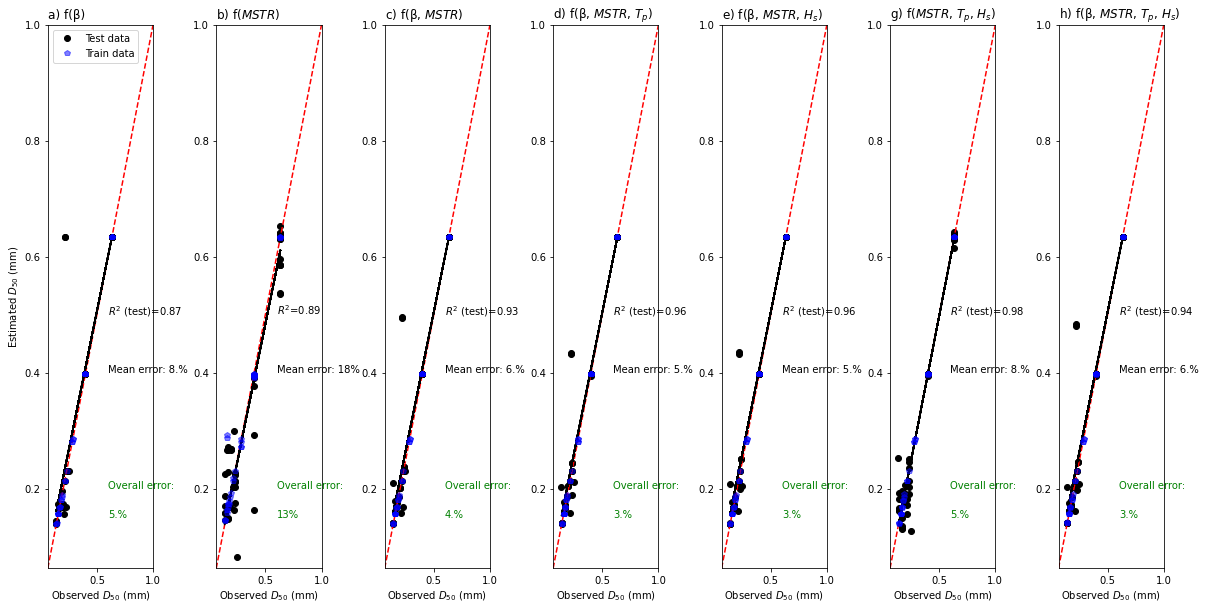

In [48]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.6, hspace=0.3)

plt.subplot(171)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko', label='Test data')
plt.xlim(0.063,1.0); plt.ylim(0.063,1.0)

yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.6,.5,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
plt.text(.6,.4, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
# plt.text(1.2,.3, r'MSE: {}mm'.format(str(Smean[0])[:4]))

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=0)

plt.text(.6,.2, r'Overall error:', color='g')
plt.text(.6,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(172)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(0.063,1.0); plt.ylim(0.063,1.0)

yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.6,.5,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.6,.4, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
# plt.text(1.2,.3, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.6,.2, r'Overall error:', color='g')
plt.text(.6,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(173)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(0.063,1.0); plt.ylim(0.063,1.0)

yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.6,.5,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.6,.4, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
# plt.text(1.2,.3, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.6,.2, r'Overall error:', color='g')
plt.text(.6,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(174)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(0.063,1.0); plt.ylim(0.063,1.0)

yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.6,.5,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.6,.4, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
# plt.text(1.2,.3, r'MSE: {}mm'.format(str(Smean[3])[:4]))

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.6,.2, r'Overall error:', color='g')
plt.text(.6,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(175)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(0.063,1.0); plt.ylim(0.063,1.0)

yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.6,.5,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.6,.4, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
# plt.text(1.2,.3, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.6,.2, r'Overall error:', color='g')
plt.text(.6,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(176)
ds_est = model7.predict(X_test7)
plt.plot(y_test7, ds_est, 'ko')
plt.xlim(0.063,1.0); plt.ylim(0.063,1.0)

yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) f($MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.6,.5,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')
plt.text(.6,.4, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7,ds_est)))[:2]))
# plt.text(1.2,.3, r'MSE: {}mm'.format(str(Smean[6])[:4]))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.6,.2, r'Overall error:', color='g')
plt.text(.6,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test7,y_train7)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(177)
ds_est = model8.predict(X_test8)
plt.plot(y_test8, ds_est, 'ko')
plt.xlim(0.063,1.0); plt.ylim(0.063,1.0)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test8, ds_est))**2
plt.text(.6,.5,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test8, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test8, poly1d_fn(y_test8), '-k')
plt.text(.6,.4, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
# plt.text(1.2,.3, r'MSE: {}mm'.format(str(Smean[7])[:4]))

ds_est2 = model8.predict(X_train8)
plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.6,.2, r'Overall error:', color='g')
plt.text(.6,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')
#

plt.savefig('../model_plots/NI_d50-8models-skill-FINAL.jpg', dpi=300, bbox_inches='tight')

In [39]:
X = np.stack((dfNI['beach_slope_average'], dfNI['mstr'], dfNI['tp'], dfNI['hs_mean'],  rand))
ds_est8 = model8.predict(X.T)

X = np.stack((dfNI['beach_slope_average'], dfNI['mstr'], dfNI['tp'], rand))
ds_est4 = model4.predict(X.T)

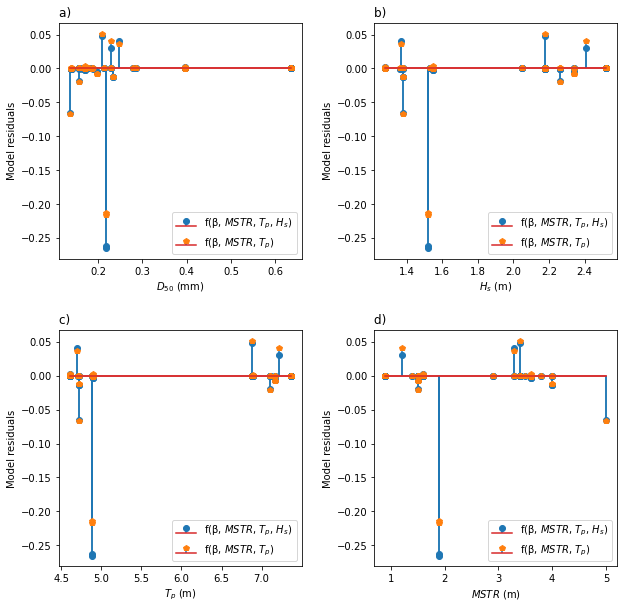

In [40]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(221)
plt.stem(dfNI['d50'], dfNI['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfNI['d50'], dfNI['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$D_{50}$ (mm)')
plt.title(r"a) ", loc='left')

plt.subplot(222)
plt.stem(dfNI['hs_mean'], dfNI['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfNI['hs_mean'], dfNI['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$H_s$ (m)')
plt.title(r"b) ", loc='left')

plt.subplot(223)
plt.stem(dfNI['tp'], dfNI['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfNI['tp'], dfNI['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$T_p$ (m)')
plt.title(r"c) ", loc='left')

plt.subplot(224)
plt.stem(dfNI['mstr'], dfNI['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfNI['mstr'], dfNI['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$MSTR$ (m)')
plt.title(r"d) ", loc='left')

plt.savefig('../model_plots/NI_d50-model8_residuals-skill-FINAL.jpg', dpi=300, bbox_inches='tight')

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

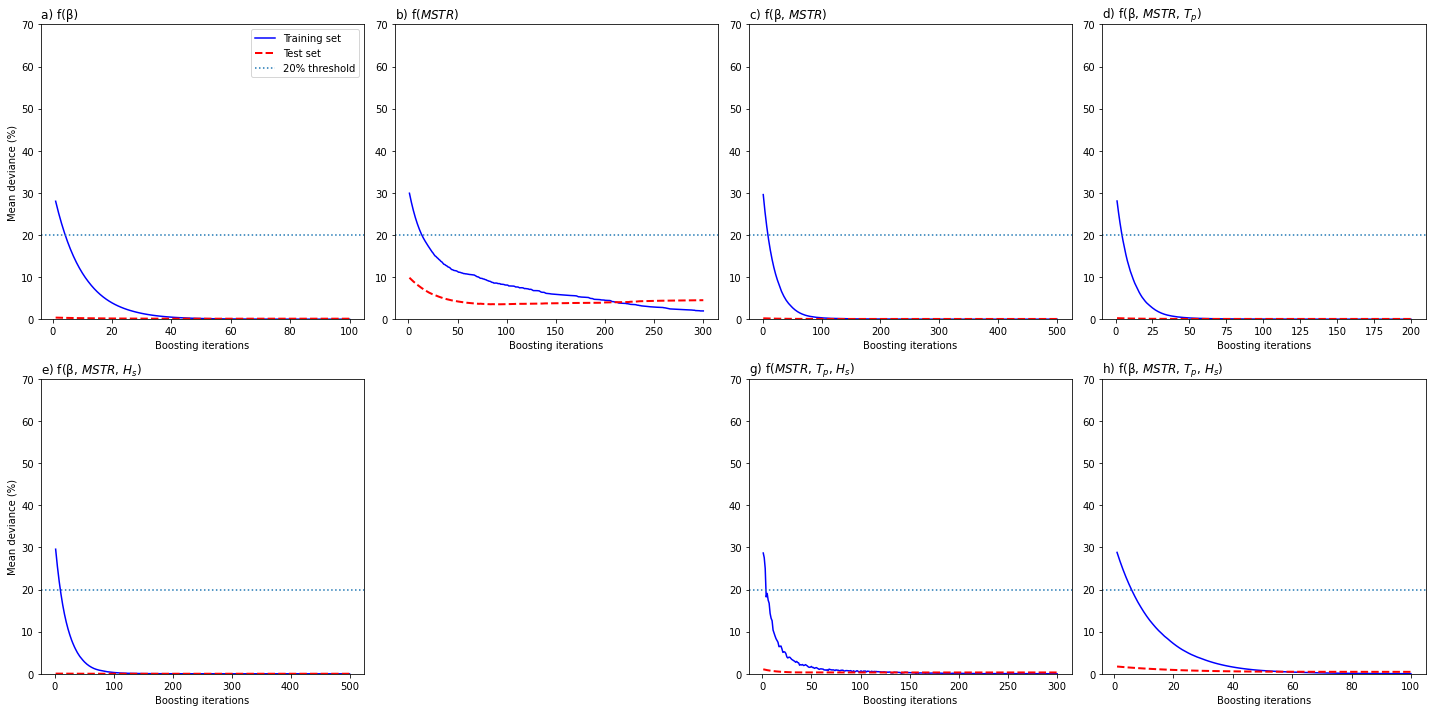

In [41]:
mm = dfNI['d50'].mean()


fig=plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

####################
test_score = np.zeros((model1.n_estimators,), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)

plt.subplot(2, 4, 1)
plt.title(r"a) f(β)", loc='left')
plt.plot(
    np.arange(model1.n_estimators) + 1,
    100*(np.sqrt(model1.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model1.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (%)")
plt.ylim(0,70)
plt.legend(loc=0)

###########################
test_score = np.zeros((model2.n_estimators,), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)

plt.subplot(2,4, 2)
plt.title(r"b) f($MSTR$)", loc='left')
plt.plot(
    np.arange(model2.n_estimators) + 1,
    100*(np.sqrt(model2.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model2.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,70)

#############################
test_score = np.zeros((model3.n_estimators,), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)

plt.subplot(2,4, 3)
plt.title("c) f(β, $MSTR$)", loc='left')
plt.plot(
    np.arange(model3.n_estimators) + 1,
    100*(np.sqrt(model3.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model3.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,70)

#####################
test_score = np.zeros((model4.n_estimators,), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(2, 4, 4)
plt.title(r"d) f(β, $MSTR$, $T_p$) ", loc='left')
plt.plot(
    np.arange(model4.n_estimators) + 1,
    100*(np.sqrt(model4.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model4.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,70)

#####################
test_score = np.zeros((model5.n_estimators,), dtype=np.float64)
for i, y_pred5 in enumerate(model5.staged_predict(X_test5)):
    test_score[i] = model5.loss_(y_test5, y_pred5)
    
plt.subplot(2,4, 5)
plt.title(r"e) f(β, $MSTR$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model5.n_estimators) + 1,
    100*(np.sqrt(model5.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model5.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (%)")
plt.ylim(0,70)

# #####################
# test_score = np.zeros((model6.n_estimators,), dtype=np.float64)
# for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
#     test_score[i] = model6.loss_(y_test6, y_pred6)
    
# plt.subplot(2, 4, 6)
# plt.title(r"f) f(β, $MSTR$, $\theta$) ", loc='left')
# plt.plot(
#     np.arange(model6.n_estimators) + 1,
#     100*(np.sqrt(model6.train_score_)/mm),
#     "b-",
#     label="Training set",
# )
# plt.plot(
#     np.arange(model6.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
# )
# plt.axhline(20, linestyle=':',label='20% threshold')
# # plt.legend(loc="upper right")
# plt.xlabel("Boosting iterations")
# # plt.ylabel("Deviance (non-dim.)")
# plt.ylim(0,70)

#####################
test_score = np.zeros((model7.n_estimators,), dtype=np.float64)
for i, y_pred7 in enumerate(model7.staged_predict(X_test7)):
    test_score[i] = model7.loss_(y_test7, y_pred7)
    
plt.subplot(2, 4, 7)
plt.title(r"g) f($MSTR$, $T_p$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model7.n_estimators) + 1,
    100*(np.sqrt(model7.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model7.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,70)

#####################
test_score = np.zeros((model8.n_estimators,), dtype=np.float64)
for i, y_pred8 in enumerate(model8.staged_predict(X_test8)):
    test_score[i] = model8.loss_(y_test8, y_pred8)
    
plt.subplot(2, 4, 8)
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model8.n_estimators) + 1,
    100*(np.sqrt(model8.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model8.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,70)

fig.tight_layout()

plt.savefig('../model_plots/NI_d50-8models-training-FINAL.jpg', dpi=300, bbox_inches='tight')

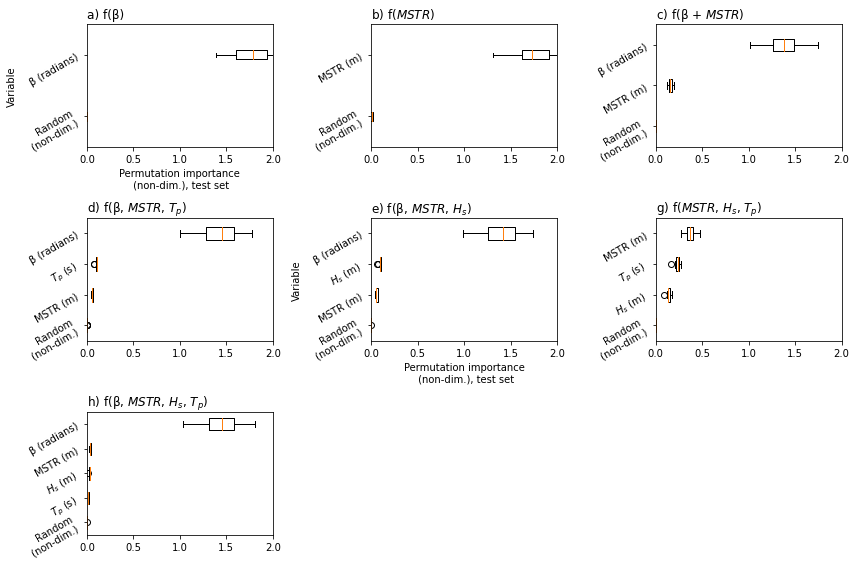

In [50]:

fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

########################
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(331)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)

plt.xlim(0,2)
plt.title("a) f(β) ", loc='left')
plt.xlabel("Permutation importance\n (non-dim.), test set")
plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

#########################
result = permutation_importance(
    model2, X_test2, y_test2, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(332)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) f($MSTR$) ", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

#############################
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(333)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)

plt.xlim(0,2)
plt.title("c) f(β + $MSTR$) ", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

############################
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(334)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

############################
result = permutation_importance(
    model5, X_test5, y_test5, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(335)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names5)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
plt.xlabel("Permutation importance\n (non-dim.), test set")
plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)


##################################
result = permutation_importance(
    model7, X_test7, y_test7, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(336)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names7)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"g) f($MSTR$, $H_s$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model8, X_test8, y_test8, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(337)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names8)[sorted_idx],
)
plt.setp(ax.get_yticklabels (), rotation=30)
plt.xlim(0,2)
plt.title(r"h) f(β, $MSTR$, $H_s$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

fig.tight_layout()

plt.savefig('../model_plots/NI_d50-8models-featimps-FINAL.jpg', dpi=300, bbox_inches='tight')

In [43]:
np.save('../model_out/dataset_NI_coast_model1_FINAL.npy', model1out, allow_pickle=True)
np.save('../model_out/dataset_NI_coast_model2_FINAL.npy', model2out, allow_pickle=True)
np.save('../model_out/dataset_NI_coast_model3_FINAL.npy', model3out, allow_pickle=True)
np.save('../model_out/dataset_NI_coast_model4_FINAL.npy', model4out, allow_pickle=True)
np.save('../model_out/dataset_NI_coast_model5_FINAL.npy', model5out, allow_pickle=True)
# np.save('../model_out/dataset_NI_coast_model6_FINAL.npy', model6out, allow_pickle=True)
np.save('../model_out/dataset_NI_coast_model7_FINAL.npy', model7out, allow_pickle=True)
np.save('../model_out/dataset_NI_coast_model8_FINAL.npy', model8out, allow_pickle=True)


In [ ]:
# [model1.get_params()['learning_rate'], model2.get_params()['learning_rate'], model3.get_params()['learning_rate'],
#  model4.get_params()['learning_rate'], model5.get_params()['learning_rate'], model6.get_params()['learning_rate'],
#  model7.get_params()['learning_rate'], model8.get_params()['learning_rate']]

In [ ]:
# [model1.get_params()['max_depth'], model2.get_params()['max_depth'], model3.get_params()['max_depth'],
#  model4.get_params()['max_depth'], model5.get_params()['max_depth'], model6.get_params()['max_depth'],
#  model7.get_params()['max_depth'], model8.get_params()['max_depth']]

In [ ]:
# [model1.get_params()['n_estimators'], model2.get_params()['n_estimators'], model3.get_params()['n_estimators'],
#  model4.get_params()['n_estimators'], model5.get_params()['n_estimators'], model6.get_params()['n_estimators'],
#  model7.get_params()['n_estimators'], model8.get_params()['n_estimators']]

In [ ]:
# [model1.get_params()['subsample'], model2.get_params()['subsample'], model3.get_params()['subsample'],
#  model4.get_params()['subsample'], model5.get_params()['subsample'], model6.get_params()['subsample'],
#  model7.get_params()['subsample'], model8.get_params()['subsample']]

In [ ]:
# [model1.get_params()['min_samples_split'], model2.get_params()['min_samples_split'], model3.get_params()['min_samples_split'],
#  model4.get_params()['min_samples_split'], model5.get_params()['min_samples_split'], model6.get_params()['min_samples_split'],
#  model7.get_params()['min_samples_split'], model8.get_params()['min_samples_split']]

In [ ]:
# [model1.get_params()['loss'], model2.get_params()['loss'], model3.get_params()['loss'],
#  model4.get_params()['loss'], model5.get_params()['loss'], model6.get_params()['loss'],
#  model7.get_params()['loss'], model8.get_params()['loss']]